In [ ]:
# File written by Maximilian Bartels

In [2]:
from sklearn.preprocessing import MinMaxScaler
import itertools
from model.action_recognition.scripts.data_processing.data_parser import read_txt_file, read_selected_folder, \
    read_all_jsons
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from tcn import TCN, tcn_full_summary

from model.data_parser import convert_jaad_dict_to_df, get_jaad_data
#Load data
data_dir = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/JAAD_per_person/"
handwaving = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/handwaving/"
handclipping = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/handclipping/"

drop_third_element = lambda lst: [x for i, x in enumerate(lst, start=1) if i % 3 != 0]
data_handwaving = [drop_third_element(list(itertools.chain.from_iterable(x))) for x in get_jaad_data(handwaving)]
data_clapping = [drop_third_element(list(itertools.chain.from_iterable(x))) for x in get_jaad_data(handclipping)]
data_hand = data_handwaving + data_clapping
df_hand = pd.DataFrame(data_hand)
scaler = MinMaxScaler()
scaler.fit(df_hand)
arr_hand = scaler.transform(df_hand)
label_array = np.array([1, 0, 1, 0])
label_df = pd.DataFrame(np.tile(label_array, (len(data_hand), 1)), columns=['look', 'action', 'hand_gesture', 'nod'])

X, Y = convert_jaad_dict_to_df(get_jaad_data(data_dir))
#X = pd.concat([pd.DataFrame(X), pd.DataFrame(arr_hand)], ignore_index=True)
#Y = pd.concat([Y, label_df], ignore_index=True)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_train_hand, X_test_hand, Y_train_hand, Y_test_hand = train_test_split(pd.DataFrame(arr_hand), label_df, test_size=0.3)
X_train = pd.concat([pd.DataFrame(X_train), X_train_hand], ignore_index=True)
X_test = pd.concat([pd.DataFrame(X_test), X_test_hand], ignore_index=True)
Y_train = pd.concat([pd.DataFrame(Y_train), Y_train_hand], ignore_index=True)
Y_test = pd.concat([pd.DataFrame(Y_test), Y_test_hand], ignore_index=True)

Starting to read JAAD json files!
Starting to read JAAD json files!
Starting to read JAAD json files!


In [41]:
def compute_f1_score(true_positives, false_positives, false_negatives):
    """
    Computes the F1 score given the number of true positives, false positives,
    and false negatives.

    Args:
    true_positives (int): Number of true positive predictions.
    false_positives (int): Number of false positive predictions.
    false_negatives (int): Number of false negative predictions.

    Returns:
    float: The F1 score.
    """
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    # Calculate F1 score using precision and recall
    if precision + recall == 0:
        f1_score = 0  # Handle the case of division by zero
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

# LSTM

In [3]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [4]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.6, name='f1_score', dtype=None), 'accuracy'])

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
3134/3136 [============================>.] - ETA: 0s - loss: 0.2747 - f1_score: 0.7773 - accuracy: 0.7367
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3136/3136 [==============================] - 60s 17ms/step - loss: 0.2747 - f1_score: 0.7773 - accuracy: 0.7367
Epoch 2/11
3134/3136 [============================>.] - ETA: 0s - loss: 0.2134 - f1_score: 0.8429 - accuracy: 0.7363
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3136/3136 [==============================] - 52s 17ms/step - loss: 0.2134 - f1_score: 0.8429 - accuracy: 0.7362
Epoch 3/11
3136/3136 [==============================] - ETA: 0s - loss: 0.1946 - f1_score: 0.8533 - accuracy: 0.7183
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/save

Accuracy: 0.8449803492942025


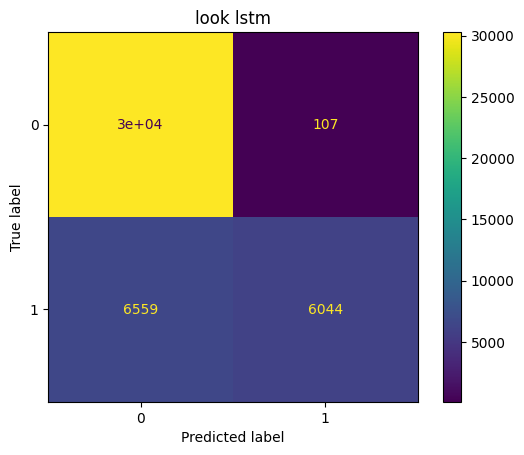

Accuracy: 0.8747238436315434


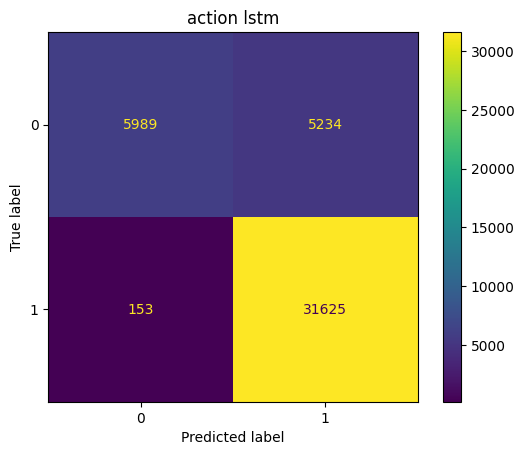

Accuracy: 0.9963954326643566


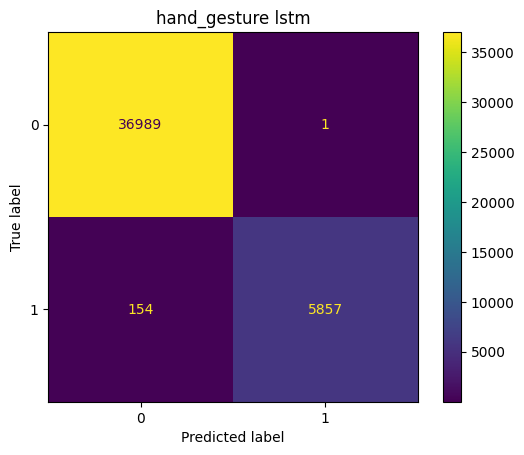

Accuracy: 0.9993488523522709


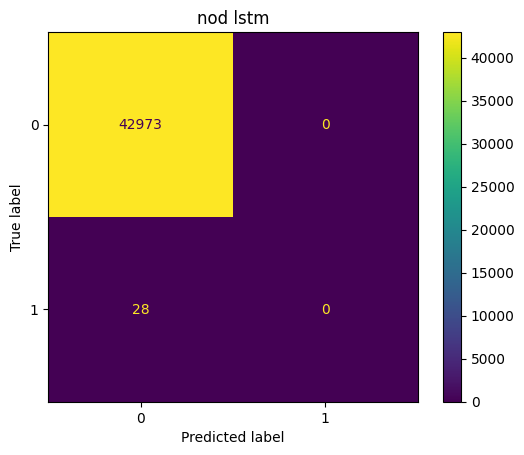

In [5]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix((Y_test.to_numpy())[:, i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

In [46]:
compute_f1_score(6044, 107, 6559)

0.6445558280900074

In [6]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_05_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [7]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.5, name='f1_score', dtype=None)])

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
3135/3136 [============================>.] - ETA: 0s - loss: 0.2558 - f1_score: 0.8122
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0001.ckpt
3136/3136 [==============================] - 62s 18ms/step - loss: 0.2558 - f1_score: 0.8122
Epoch 2/11
3135/3136 [============================>.] - ETA: 0s - loss: 0.2121 - f1_score: 0.8448
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0002.ckpt
3136/3136 [==============================] - 53s 17ms/step - loss: 0.2121 - f1_score: 0.8448
Epoch 3/11
3136/3136 [==============================] - ETA: 0s - loss: 0.1981 - f1_score: 0.8523
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0003.ckpt
3136/3136 [==============================] - 54s 17m

Accuracy: 0.8511895072207623


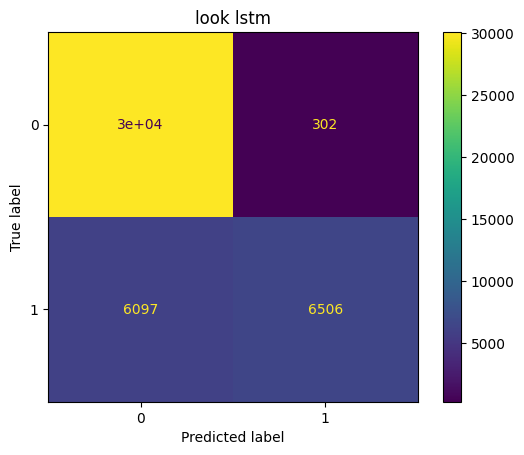

Accuracy: 0.8762354363852003


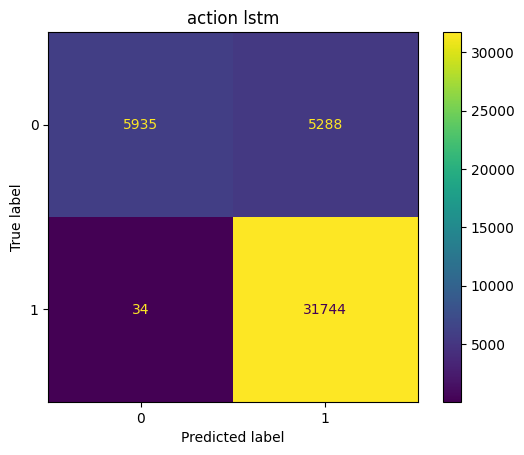

Accuracy: 0.9968837934001535


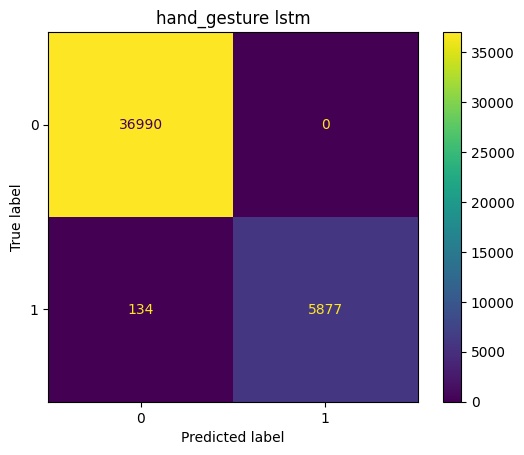

Accuracy: 0.9993488523522709


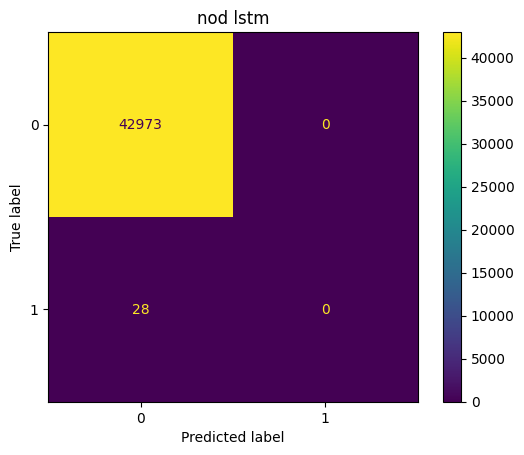

In [8]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

In [48]:
compute_f1_score(31744, 5288, 34)

0.9226565906118297

# TCN

In [9]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_tcn_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1910 - f1_score: 0.8507
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 163s 155ms/step - loss: 0.1910 - f1_score: 0.8507
Epoch 2/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1782 - f1_score: 0.8578
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 178s 178ms/step - loss: 0.1782 - f1_score: 0.8578
Epoch 3/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1746 - f1_score: 0.8589
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_rec

Accuracy: 0.852933652705751


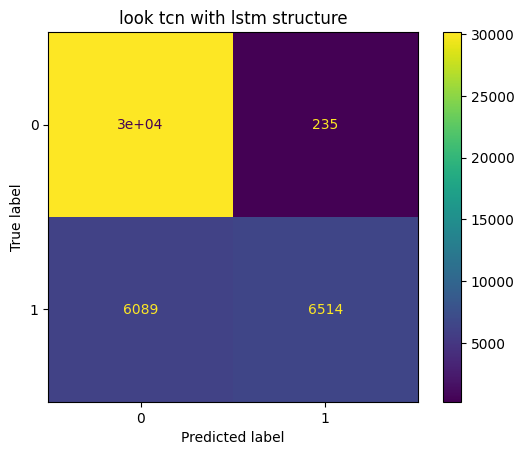

Accuracy: 0.8819794888490965


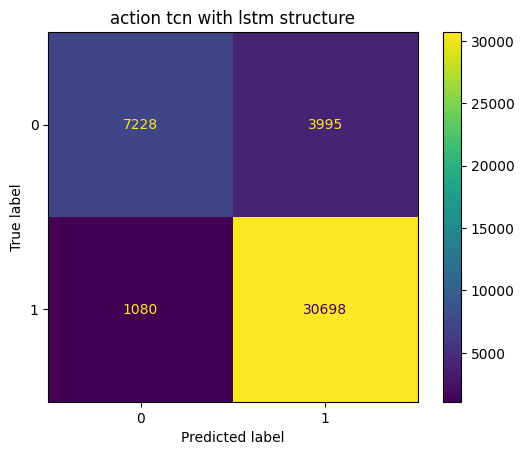

Accuracy: 0.9974186646822167


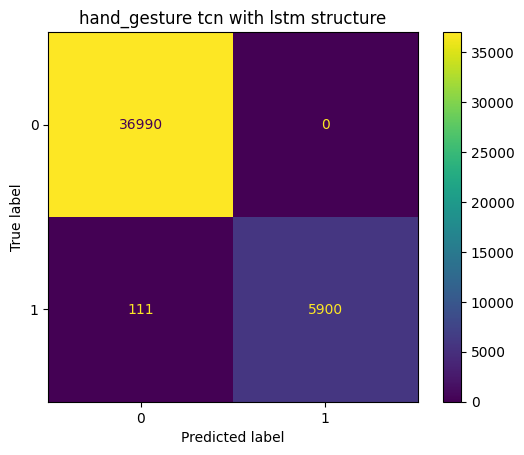

Accuracy: 0.9993488523522709


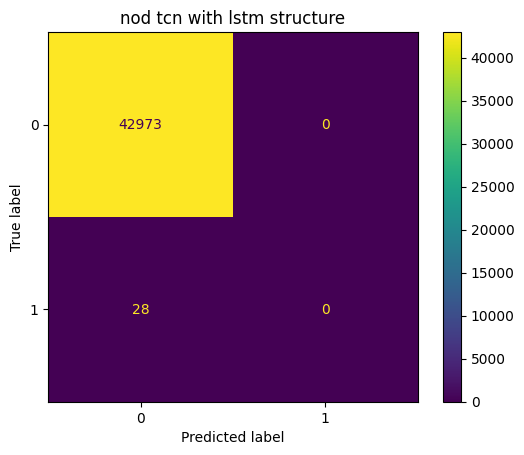

In [11]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [50]:
compute_f1_score(30693, 3995, 1080)

0.9236394276342516

In [12]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_lstm_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [13]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.5, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1958 - f1_score: 0.8507
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 157s 149ms/step - loss: 0.1958 - f1_score: 0.8507
Epoch 2/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1787 - f1_score: 0.8592
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 178s 178ms/step - loss: 0.1787 - f1_score: 0.8592
Epoch 3/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1751 - f1_score: 0.8628
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_rec

Accuracy: 0.8578405153368527


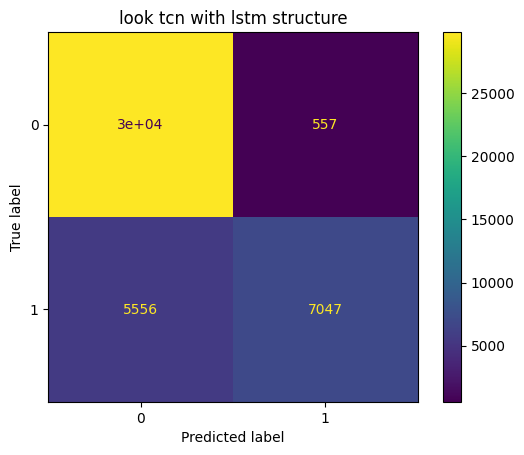

Accuracy: 0.8898862817143788


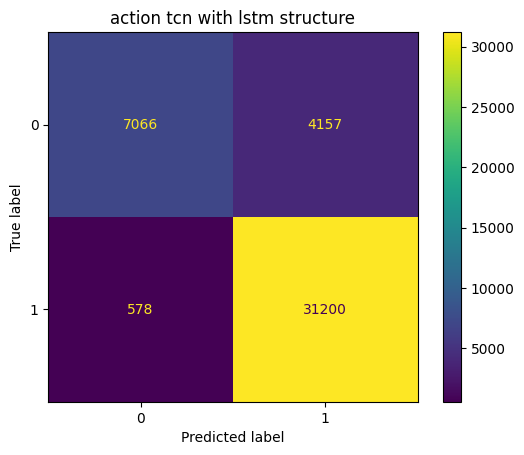

Accuracy: 0.997325643589684


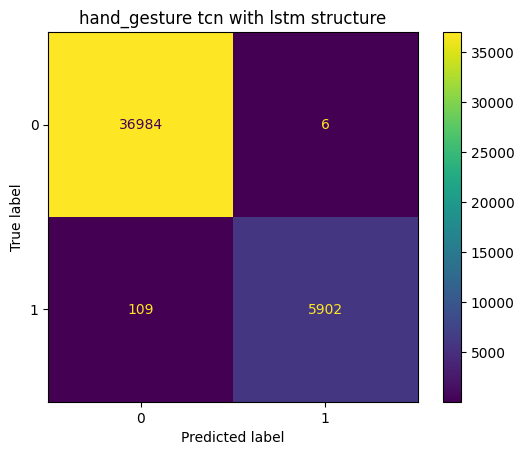

Accuracy: 0.9993488523522709


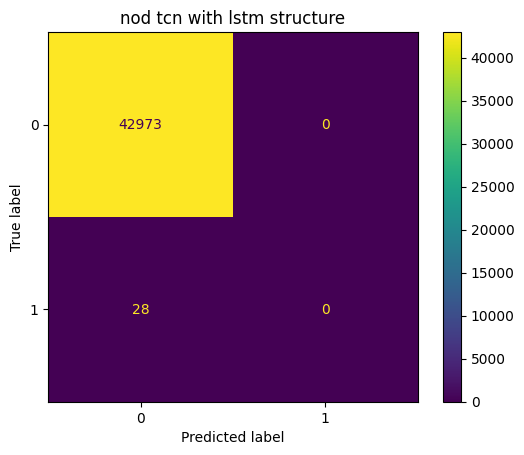

In [14]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [52]:
compute_f1_score(31200, 4157, 578)

0.9294704699486109

In [15]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [16]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

history = m.fit(X_train, Y_train,  epochs=10, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2013 - f1_score: 0.8445
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_06.ckpt
1000/1000 [==============================] - 163s 155ms/step - loss: 0.2013 - f1_score: 0.8445
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1789 - f1_score: 0.8567
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_06.ckpt
1000/1000 [==============================] - 181s 181ms/step - loss: 0.1789 - f1_score: 0.8567
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1750 - f1_score: 0.8585
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognitio

Accuracy: 0.856235901490663


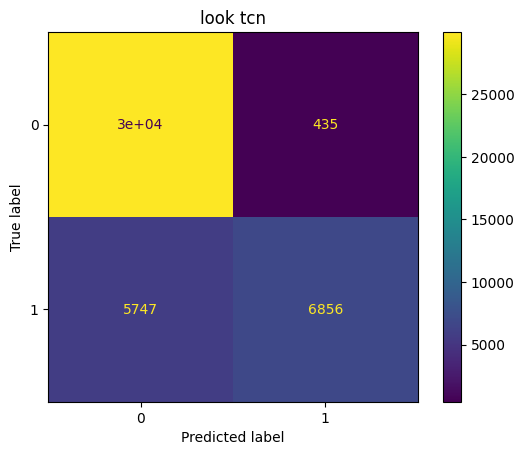

Accuracy: 0.8898862817143788


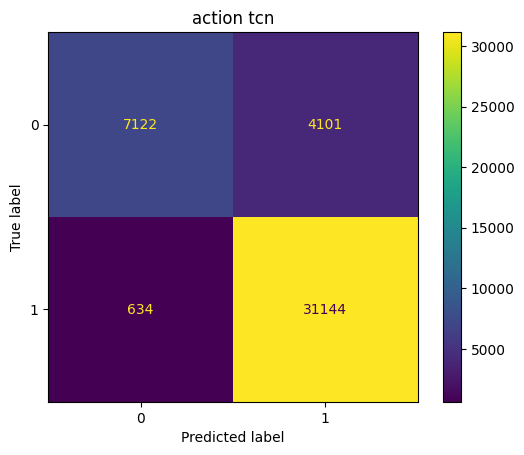

Accuracy: 0.9975349410478827


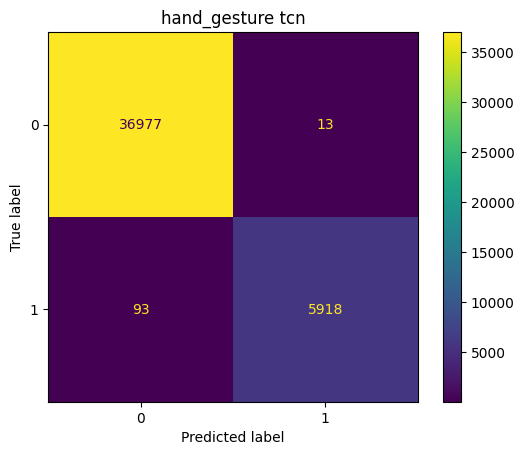

Accuracy: 0.9993023418060045


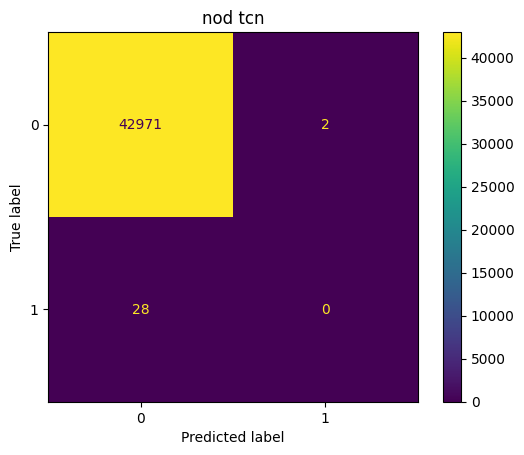

In [17]:
i = 0
for col in Y_train.columns:
    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn')
    plt.show()
    i += 1

In [54]:
compute_f1_score(31144, 4104, 634)

0.9293110136364992

In [18]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

history = m.fit(X_train, Y_train,  epochs=10, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2144 - f1_score: 0.8421
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 381s 374ms/step - loss: 0.2144 - f1_score: 0.8421
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1788 - f1_score: 0.8580
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 370s 370ms/step - loss: 0.1788 - f1_score: 0.8580
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1757 - f1_score: 0.8585
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognitio

Accuracy: 0.8576544731517872


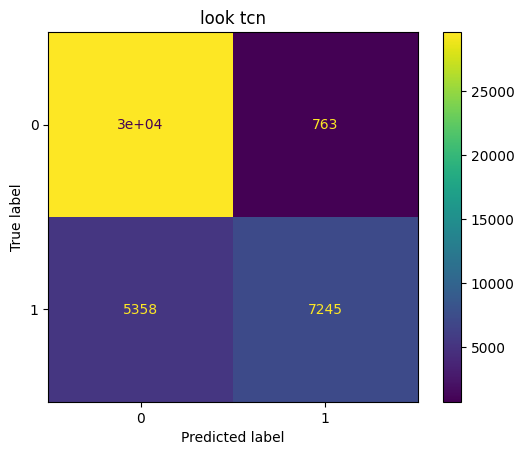

Accuracy: 0.885467779819074


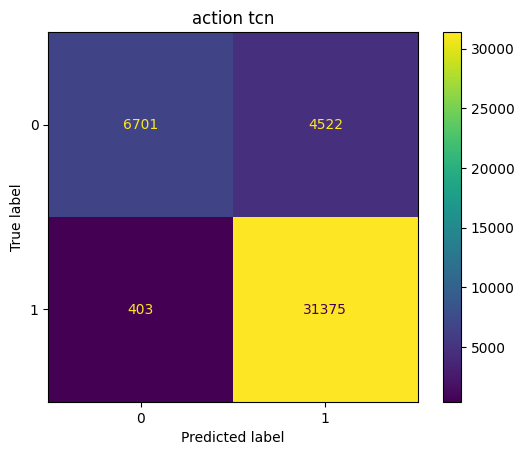

Accuracy: 0.9976744726866817


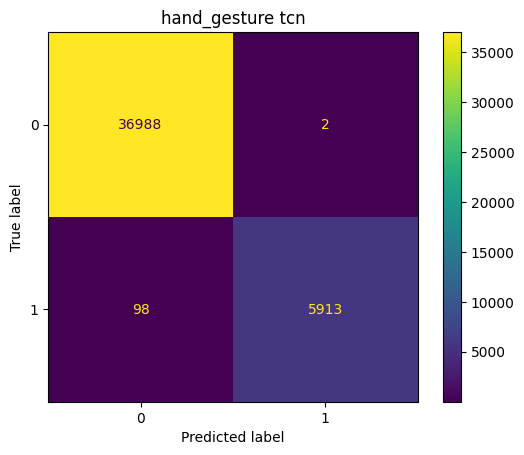

Accuracy: 0.9993488523522709


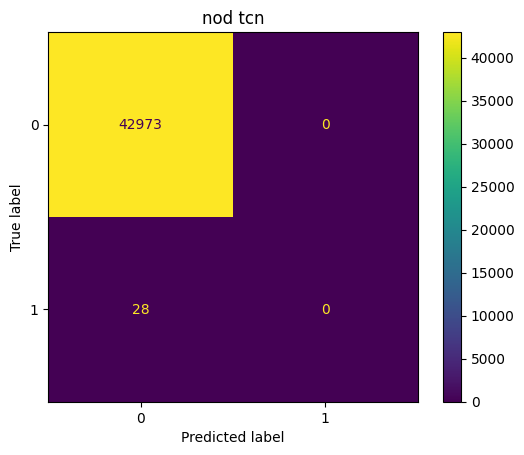

In [21]:
i = 0
for col in Y_train.columns:
    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn')
    plt.show()
    i += 1

In [56]:
compute_f1_score(31375, 4522, 403)

0.9272257111193204

In [22]:
for col in Y.columns:
    print(col)
    print(Y[col].count())
    print(Y[col].sum())
    print((Y[col].sum() / Y[col].count()) * 100)

look
123656
22337.0
18.0638222164715
action
123656
105754.0
85.52274050591964
hand_gesture
123656
369.0
0.29840848806366044
nod
123656
109.0
0.08814776476677233
